# Maria Chernyavskaya, Lab 7&8, Section AB

In [1]:
# import pyuvdata everytime for JupyterHub
! conda install pyuvdata -y > /dev/null



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda




In [2]:
%matplotlib inline
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import stats
import matplotlib.colors as colors
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
uv = UVData()
uv.read('/home/jovyan/Phys434_BigData/zen.2459122.62018.mini.sum.uvh5')
pairs = uv.get_antpairs()
background = []
for i in range(len(pairs)):
    dat = np.abs(uv.get_data(pairs[i]))
    dat = dat[3]
    background.append(dat)
    
freqs = uv.freq_array.flatten() * 1e-6
avgbackground = (np.array(background)).mean(axis=0)

In [5]:
bl1=pairs[506]
d1 = uv.get_data(bl1)
d1.shape

(20, 1536)

## HERA Labs 7 & 8
The ultimate goal in the following is to 
a) Identify contaminants, and remove them from the dataset 
b) Determine how much more sensitive your measurement is after the cuts (compared to before)

If the data size is getting unwieldy, feel free to use only part of the file.

## Initial data axes
Just to be clear, your initial dataset should have the following axes:

𝑣𝑎𝑏  (each cross-power measurement between antennas  𝑎  and  𝑏 . This labelled  𝑣𝑎𝑏  because the measurements are called 'visibilities'. A complex quantity in Jansky units.)

𝑡𝑛  (each time step, seconds units.)

𝑓  (each frequency, in MHz)


Morales's hints:
* 2D histogram of real vs imaginary
* phases removed bc of imaginary being scrapped by absolute
* phase is time delay

## Signal removal
The data contains both sky signal (good) and contamination (bad). To make a background distribution, we really need to remove the sky signal. The sky signal in this data is very steady in time. Most of the sources are distant radio galaxies who's intensity (brightness) is steady over millions of years, and they move slowly across the sky. But our measurements are every ~10 seconds. So we can remove the astrophysical signals by subtracting neighboring time samples. Many of the contaminants have a lot of variability, either because the brightness is quickly fluctuating or they are rapidly moving on the sky. So this procedure will remove most of the sky signal, but much of the contamination we are looking for will remain.

After you do this you sould have the following axes:  𝑣𝑎𝑏 ,  Δ𝑡=𝑡𝑛+1−𝑡𝑛 , and  𝑓 , and we'll use this for the duration. You will also want to ignore when  𝑎=𝑏  measurements (e.g.  𝑣𝑎𝑎  if they exist).

In [9]:
def rm_bkg(bl):
    sr1 = []
    for i in range(19):
        sr1.append(bl[i+1]-bl[i])
    sr1=np.array(sr1)
    return sr1

In [10]:
sr1=rm_bkg(d1)

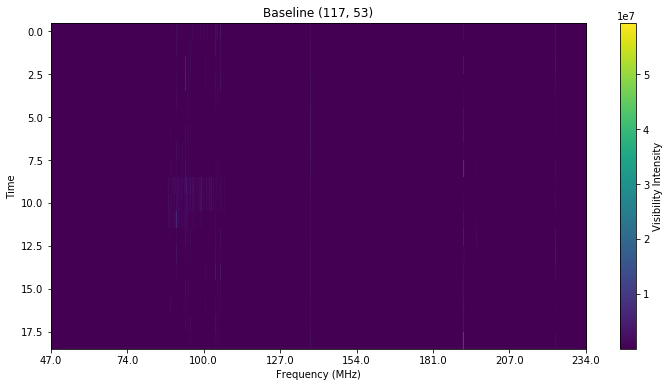

In [11]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.abs(sr1),aspect='auto')
cbar = fig.colorbar(im,label='Visibility Intensity')
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {bl1}')
plt.show()

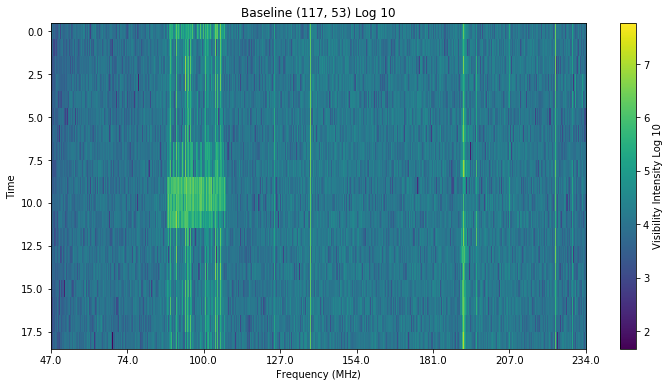

In [12]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log10(np.abs(sr1)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {bl1} Log 10')
plt.show()

## Waterfall plots
One particularly usefull plot is a waterfall plot (why it is called this is very obscure), a plot of the power  𝑣  vs. time and frequency. The idea is to have a 2D plot showing the magnitude of the visibility  |𝑣𝑎𝑏|  versus time and frequency, with all axes labelled and in the appropriate units.

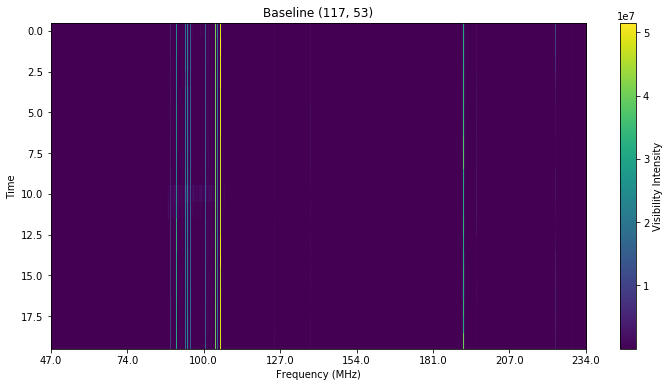

In [6]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.abs(d1),aspect='auto')
cbar = fig.colorbar(im,label='Visibility Intensity')
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {bl1}')
plt.show()

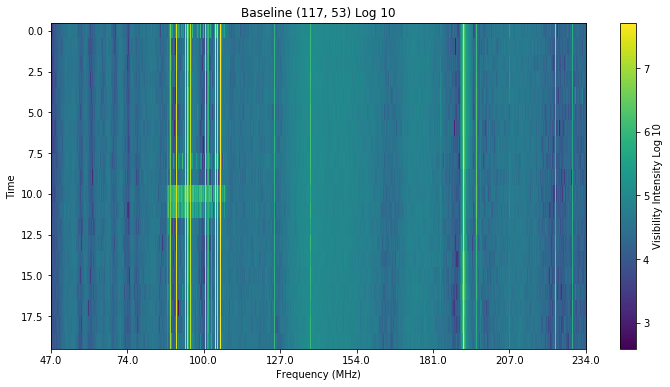

In [7]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log10(np.abs(d1)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,8)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {bl1} Log 10')
plt.show()

## Single antenna pair plots
Pick the visibilities from a single antenna pair. Plot both the waterfall and a histogram of the magnitude of the visibility.

Comment on why we are histogramming the magnitude. Describe the basic shape.

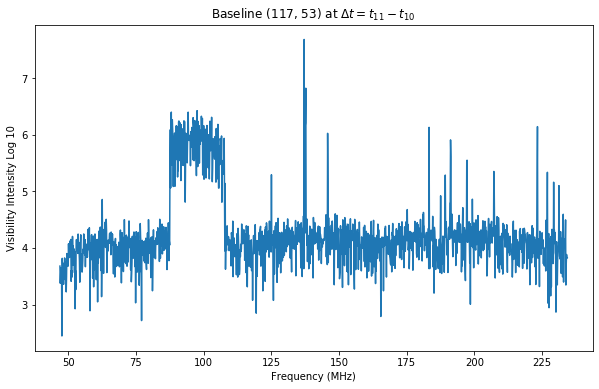

In [17]:
n=10
plt.subplots()
plt.plot(freqs,np.log10(np.abs(sr1[n])))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Intensity Log 10')
plt.title(fr"Baseline {bl1} at $\Delta t = t_{ {n+1} } - t_{ {n} }$",fontsize=12);

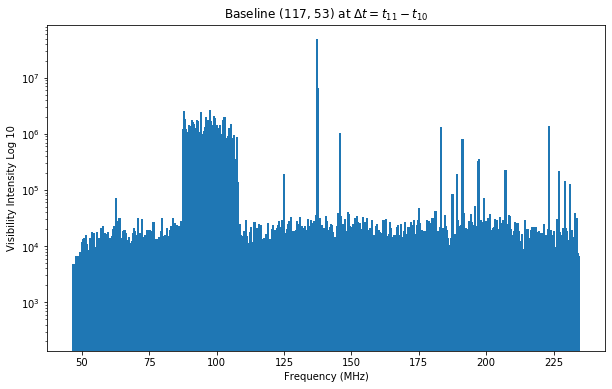

In [18]:
plt.subplots()
plt.yscale('log')
plt.bar(freqs,(np.abs(sr1[n])))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Intensity Log 10')
plt.title(fr"Baseline {bl1} at $\Delta t = t_{ {n+1} } - t_{ {n} }$",fontsize=12);

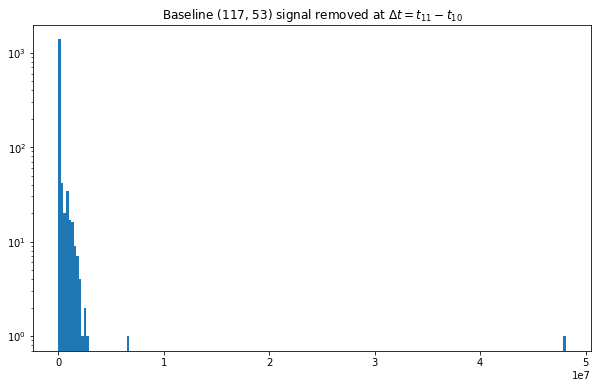

In [19]:
plt.subplots()
plt.yscale('log')
plt.hist(np.abs(sr1[n]),bins=200);
plt.title(fr"Baseline {bl1} signal removed at $\Delta t = t_{ {n+1} } - t_{ {n} }$",fontsize=12);

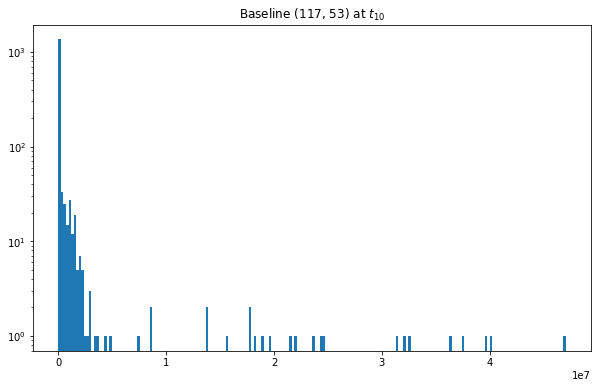

In [20]:
plt.subplots()
plt.yscale('log')
plt.hist(np.abs(d1[n]),bins=200);
plt.title(fr"Baseline {bl1} at $t_{ {n} }$",fontsize=12);

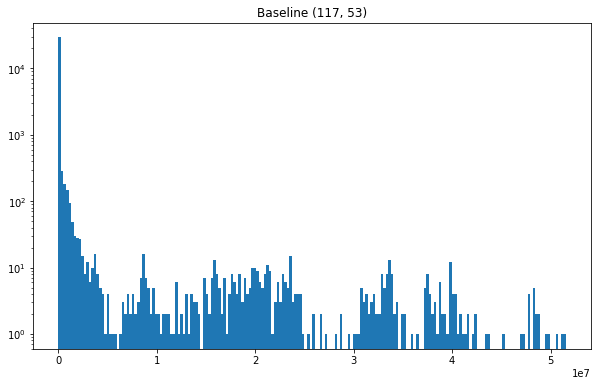

In [21]:
plt.subplots()
plt.yscale('log')
plt.hist(np.abs(d1.flatten()),bins=200);
plt.title(fr"Baseline {bl1}",fontsize=12);

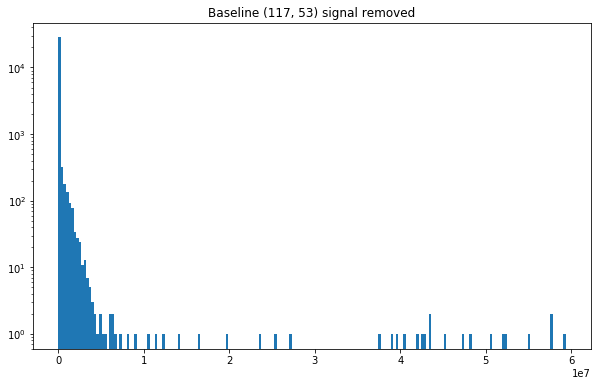

In [22]:
plt.subplots()
plt.yscale('log')
plt.hist(np.abs(sr1.flatten()),bins=200);
plt.title(fr"Baseline {bl1} signal removed",fontsize=12);

## Average visibility plots
If a signal comes from far away, we will expect to see it in all antenna pairs. So to increase our sensitivity we can average all of the baseline pairs (make sure to not include the  𝑣𝑎𝑎  values). But because the visibilities are complex, we have to be careful. What we really want is the average of the magnitudes  <|𝑣|>𝑎𝑏 , where  𝑎  and  𝑏  cover all values  𝑎≠𝑏 .

Make the associated waterfall and histogram plots, explore and describe.

If your distribution is not centered at zero it may be useful to subtract the average value. If you go down this road, explore whether you want to subtract the global average, or an average per frequency or per time.

In [24]:
ns=[]
for i in range(len(pairs)):
    if pairs[i][0]!=pairs[i][1]:
        ns.append(pairs[i])

In [26]:
len(ns)

630

## Feature exploration
Describe the features you are seeing as accurately as you can. For some of the data files the following might be helpful https://www.ee.co.za/wp-content/uploads/2015/03/csir-035-02-2015_.jpg

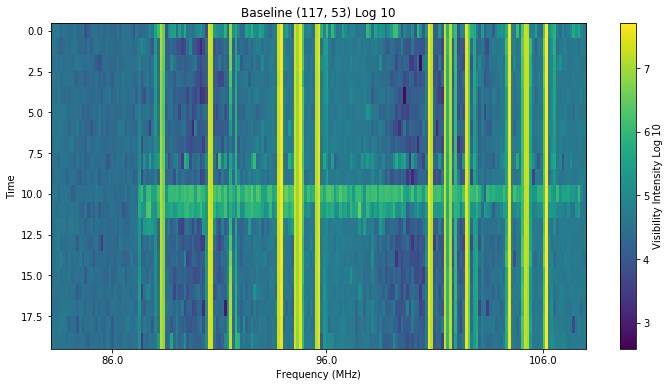

In [8]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
im = plt.imshow(np.log10(np.abs(d1)),aspect='auto',interpolation='nearest')
cbar = fig.colorbar(im,label='Visibility Intensity Log 10')
freqs = uv.freq_array[0]*1e-6 #gets frequencies associated with each channel, in MHz
axs.set_ylabel('Time')
axs.set_xlabel('Frequency (MHz)')
xticks = [int(i) for i in np.linspace(0,len(freqs)-1,20)]
_ = axs.set_xticks(xticks)
xticklabels = np.around(freqs[xticks],0)
_ = axs.set_xticklabels(xticklabels)
plt.title(f'Baseline {bl1} Log 10')
plt.xlim(300,500)
plt.show()

## Jackknife plots
You may be seeing features already, but there may be features that are still below the level you can see by eye. For this we will need a jackknife test. The steps to any jackknife test are:

a) Come up with a concern (state clearly)

b) Identify a data cut, where if the concern is true the contamination should appear in one data set but not the other.

c) Calculate the histograms for each dataset, including the error bars on the histogram. Plot the histograms.

d) For the actual jackknife, subtract the histograms and see whether they are consistent to within the expected error (note the errors on the difference are not identical to the errors on each histogram individually.).

Perform a jackknife test or two. Clearly describe whether the jackknife passed (statistically identical) or failed (there is a difference), and what this means about your initial concern in part a).

## Data cuts
Based on your identified features and jackknife tests, come up with a set of cuts to remove contaminated data.

After your cuts, recalculate the average visibility histogram, and compare it to what you had before.

If you had a candidate signal in this space, what is the significance of your detection before and after removing the contamination? Discuss in detail. This is the key step in the entire course, so really think about it. Normally we'd want to include as much data as possible to increase sensitivity, but here we are choosing to remove data. Why?